In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv("http://hilpisch.com/pyalgo_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB
None


In [3]:
data = pd.DataFrame(raw_data['XAU='])
data.rename(columns={'XAU=':'price'}, inplace=True)

<Axes: xlabel='Date'>

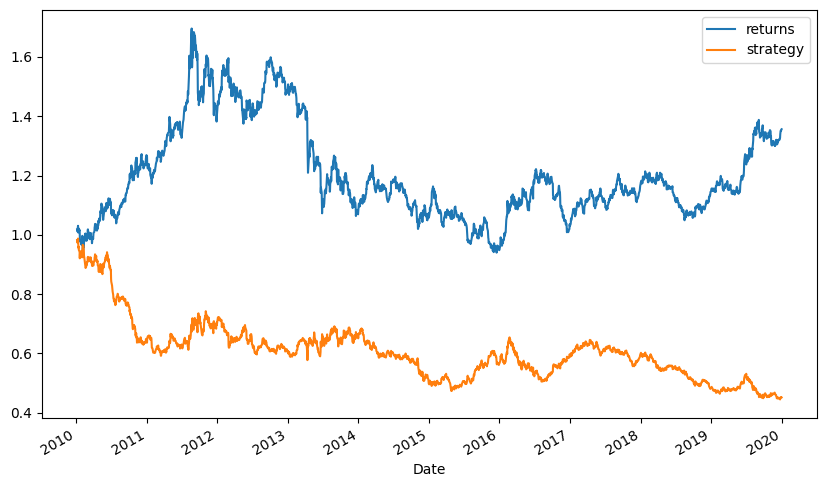

In [4]:
# Without Rolling Window
data['returns'] = np.log(data['price']/data['price'].shift(1))
data['position'] = np.sign(data['returns'])
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))


<Axes: xlabel='Date'>

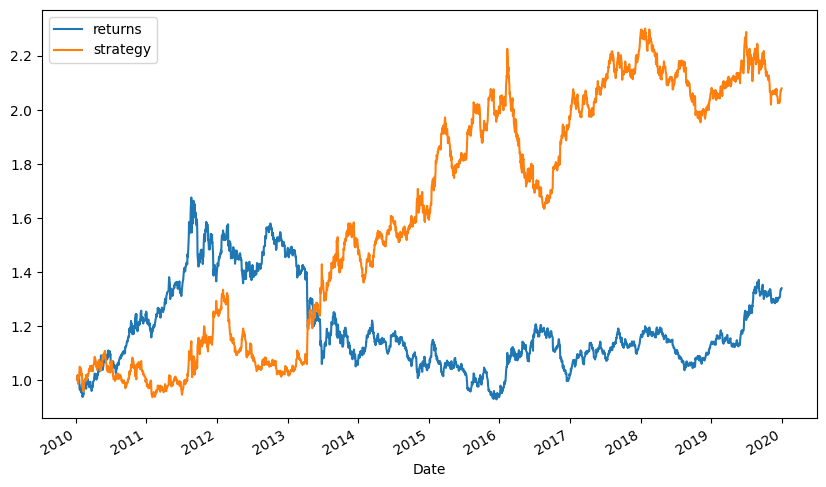

In [5]:
# Rolling Window Approach
data['position'] = np.sign(data['returns'].rolling(3).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

In [6]:
aapl_data = '../data/AAPL_1min_05052020.csv'
data = pd.read_csv(aapl_data, index_col=0, parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-05-05 16:00:00 to 2020-05-05 20:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    241 non-null    float64
 1   LOW     241 non-null    float64
 2   OPEN    241 non-null    float64
 3   CLOSE   241 non-null    float64
 4   COUNT   241 non-null    float64
 5   VOLUME  241 non-null    float64
dtypes: float64(6)
memory usage: 13.2 KB


In [7]:
data['returns'] = np.log(data['CLOSE']/data['CLOSE'].shift(1))
to_plot = ['returns']
for m in [1, 3, 5, 7, 9]:
    data[f'position_{m}'] = np.sign(data['returns'].rolling(m).mean())
    data[f'strategy_{m}'] = data[f'position_{m}'].shift(1) * data['returns']
    to_plot.append(f'strategy_{m}')

<Axes: title={'center': 'AAPL Intraday (5th May 2020)'}, xlabel='Date'>

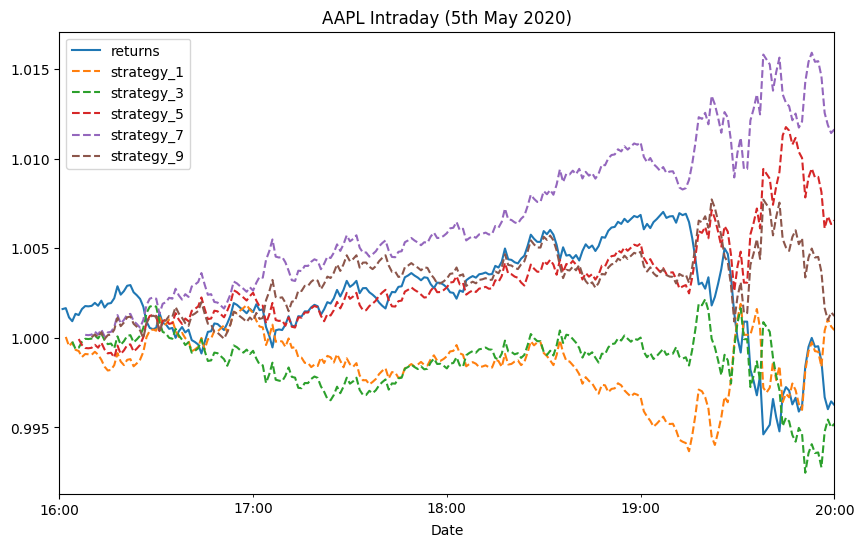

In [8]:
data[to_plot].cumsum().apply(np.exp).plot(title = 'AAPL Intraday (5th May 2020)', figsize=(10,6), style=['-','--','--','--','--','--'])

In [9]:
class MomentumVectorBacktest:
    def __init__(self, symbol, start, end, amount, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()

    def get_data(self):
        raw_data = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()
        raw_data = pd.DataFrame(raw_data[self.symbol])
        raw_data = raw_data.loc[self.start:self.end]
        raw_data.rename(columns={self.symbol:'price'}, inplace=True)
        raw_data['returns'] = np.log(raw_data/raw_data.shift(1))
        self.data = raw_data

    def run_strategy(self, momentum=1):
        self.momentum = momentum
        data = self.data.copy().dropna()
        data['position'] = np.sign(data['returns'].rolling(momentum).mean())
        data['strategy'] = data['position'].shift(1) * data['returns']
        # To find when a trade takes place
        data.dropna(inplace=True)
        trades = data['position'].diff().fillna(0) != 0
        # subtract transaction costs from returns when trade takes place 
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # absolute performance of strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)
    
    def plot_results(self):
        if self.results is None:
            print("No results to plot yet, Run a strategy first!")
        title = f'{self.symbol} | TC={round(self.tc, 4)}'
        self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(10, 6))

C:\Users\samee\AppData\Local\Temp\ipykernel_58760\1565277485.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['strategy'][trades] -= self.tc


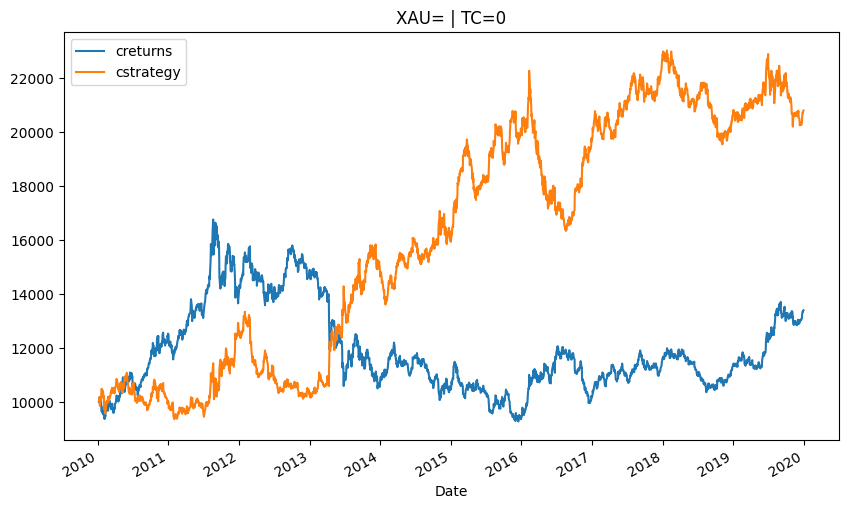

In [10]:
mbt = MomentumVectorBacktest('XAU=','2010-1-1', '2019-12-31', 10000, 0)
mbt.run_strategy(momentum=3)
mbt.plot_results()

C:\Users\samee\AppData\Local\Temp\ipykernel_58760\1565277485.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['strategy'][trades] -= self.tc


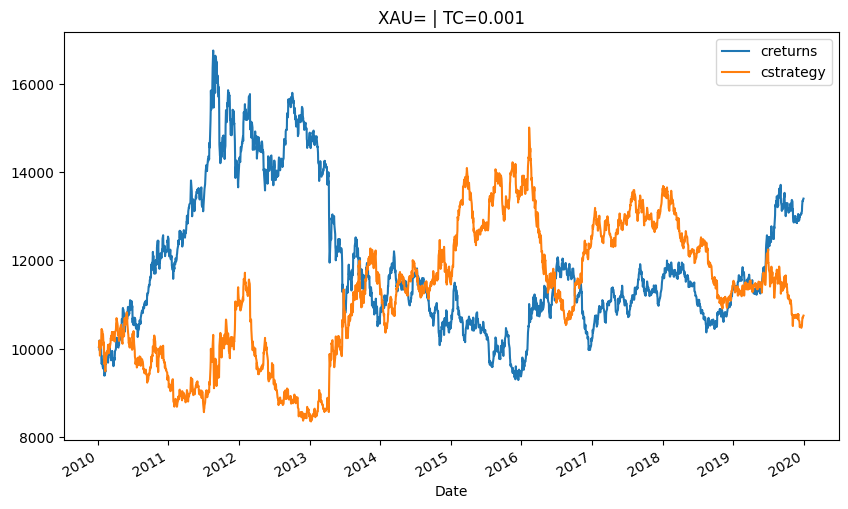

In [11]:
mbt = MomentumVectorBacktest('XAU=','2010-1-1', '2019-12-31', 10000, 0.001)
mbt.run_strategy(momentum=3)
mbt.plot_results()